In [10]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

import pandas as pd
from pandas import read_csv

from sklearn.decomposition import PCA
import umap

In [2]:
# Convert from 64 to 32 bit floats
X_test = np.load("/home/alon/school/c247a/datasets/project_data/project/X_test.npy").astype(np.float32)
y_test = np.load("/home/alon/school/c247a/datasets/project_data/project/y_test.npy").astype(np.float32)
person_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/y_train_valid.npy").astype(np.float32)
person_test = np.load("/home/alon/school/c247a/datasets/project_data/project/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


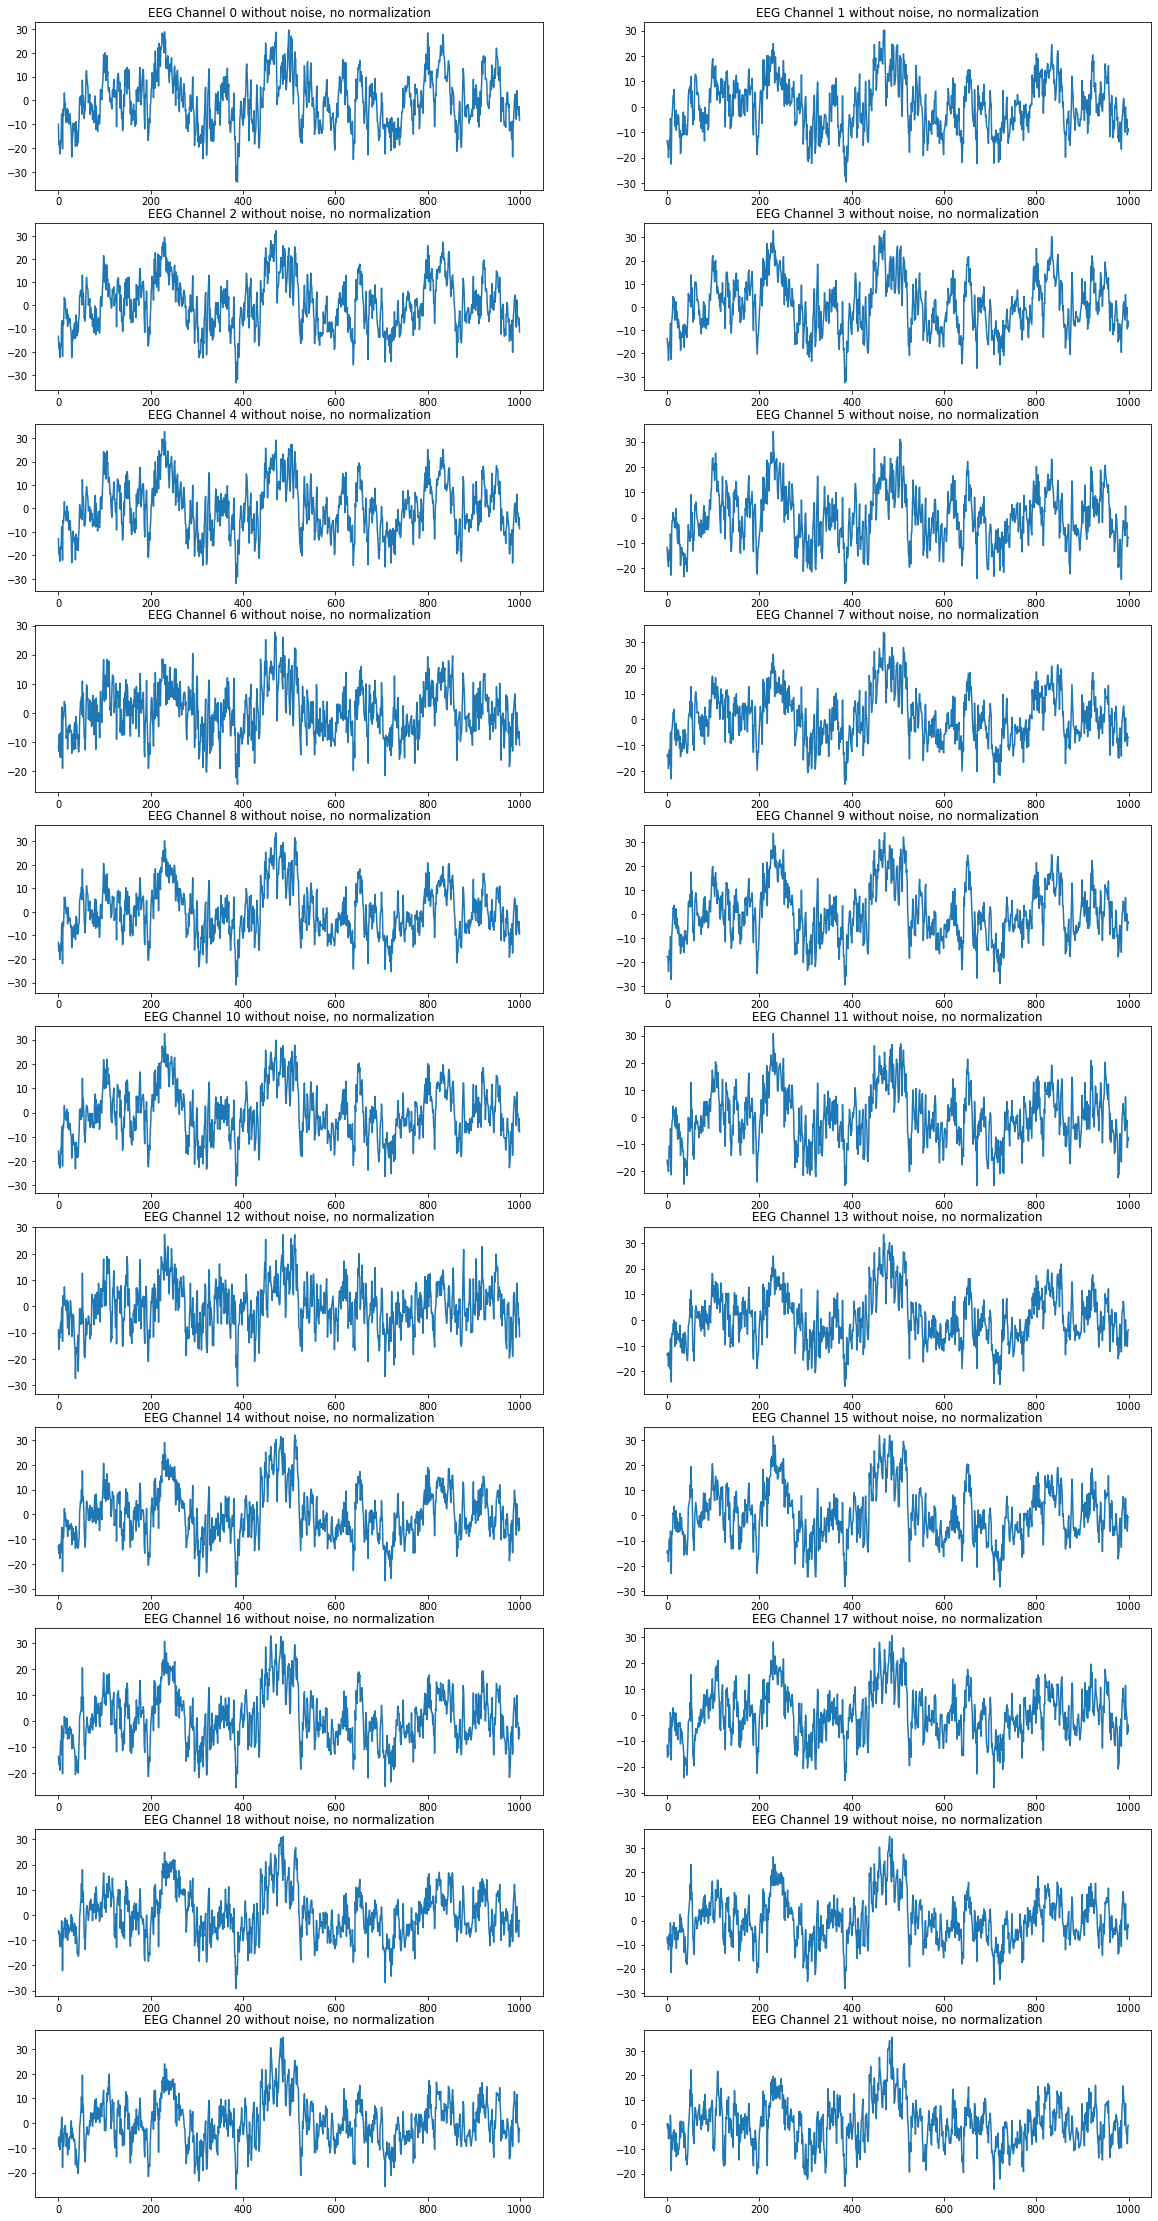

In [3]:
#take a look at a random capture

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

for i in range(22):
    axs[int(i/2),count].plot(X_train_valid[eeg_ix,i,:])
    axs[int(i/2),count].set_title('EEG Channel {} without noise, no normalization'.format(i))
    
    count += 1
    if (count>1):
        count=0

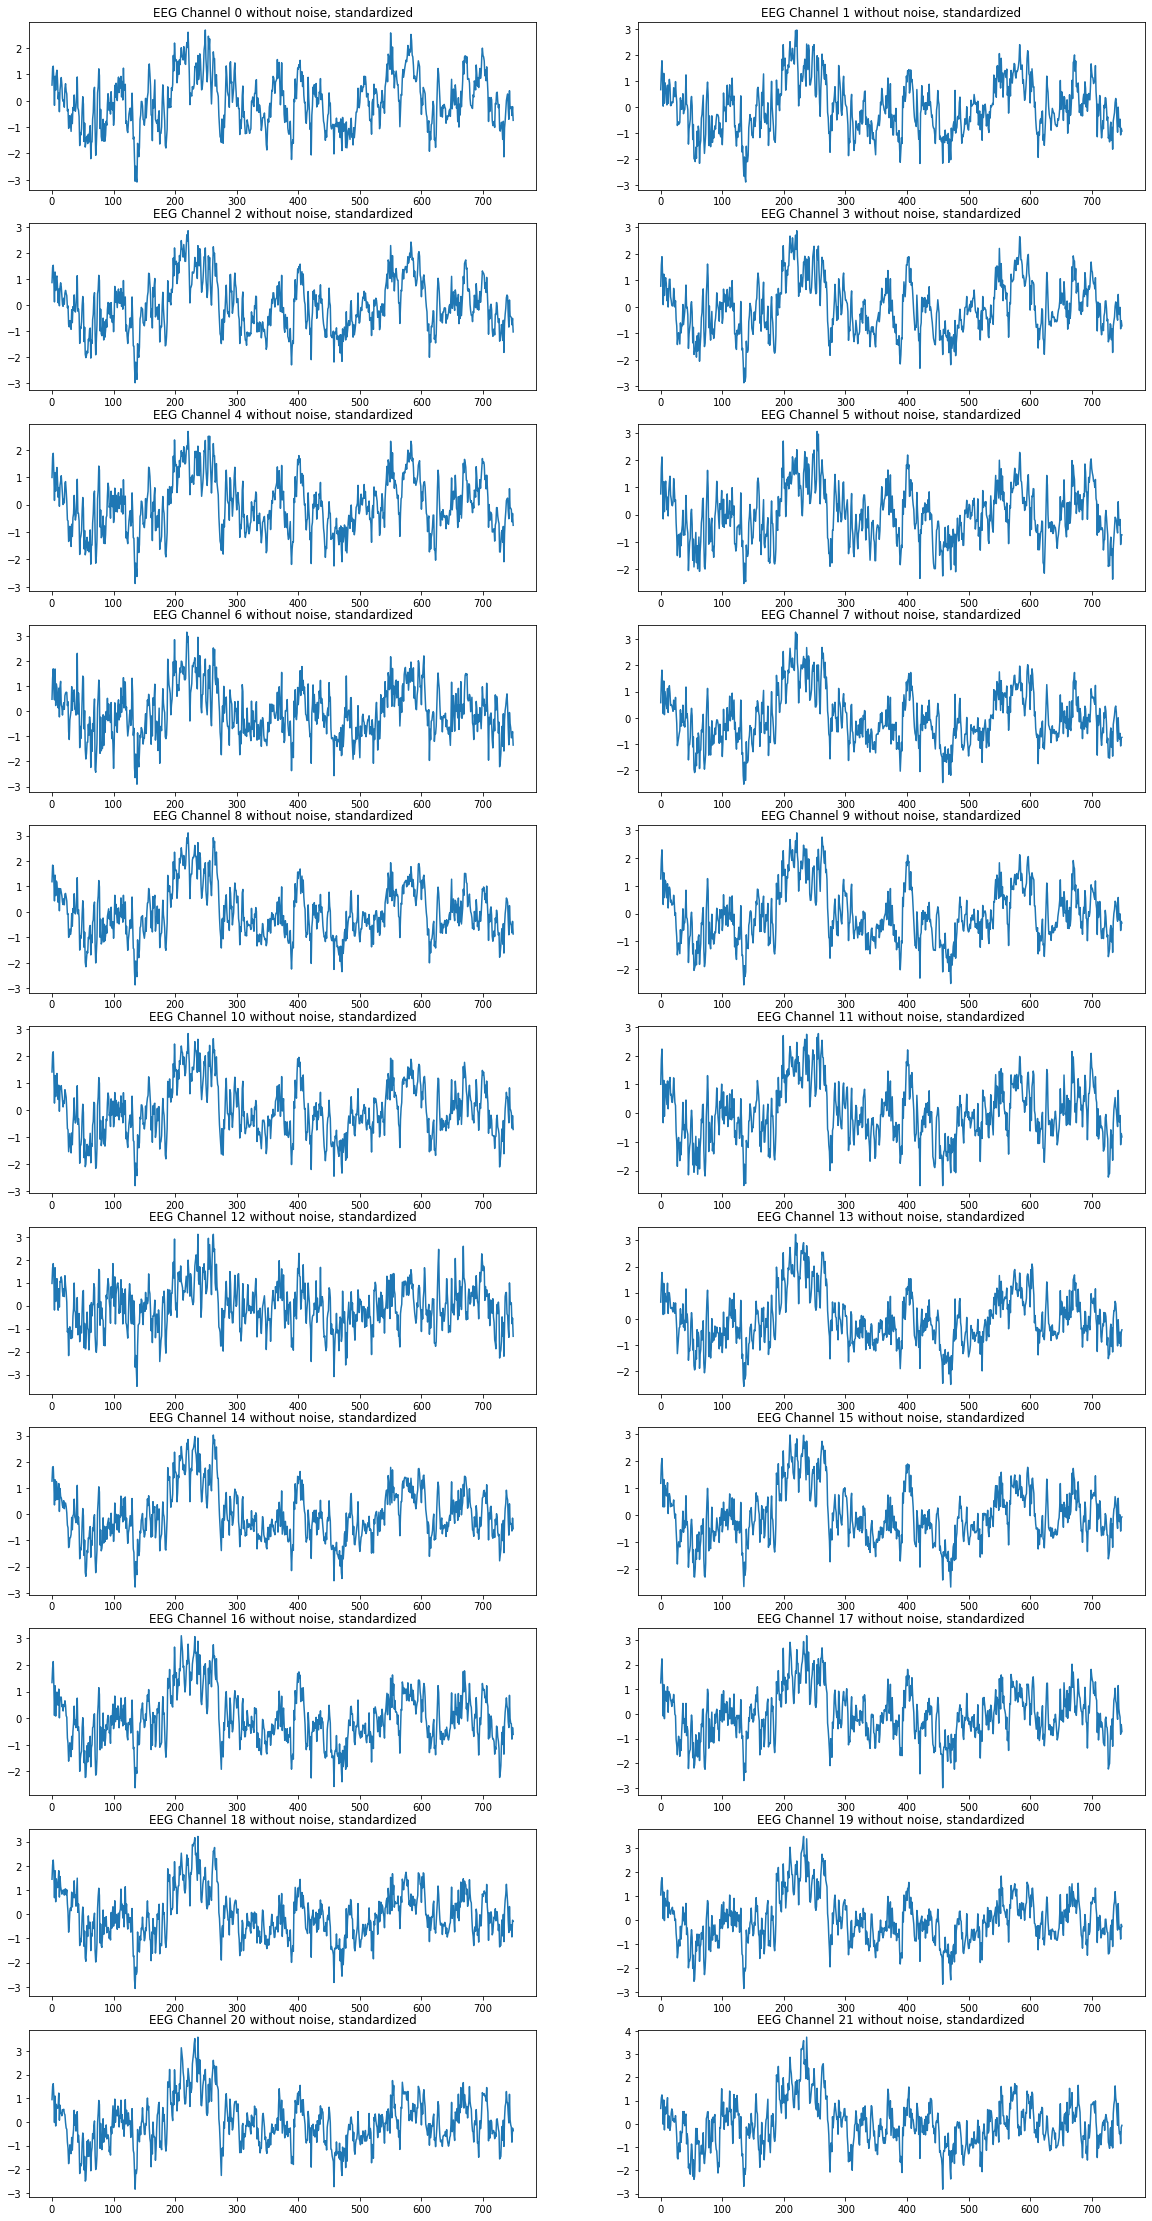

In [121]:
#normalizing each channel of a single run

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

for i in range(22):
    y = X_train_valid[eeg_ix,i,250:]
    mean = np.mean(y)
    std = np.std(y)
    z = (y-mean)/std
    
    axs[int(i/2),count].plot(z)
    axs[int(i/2),count].set_title('EEG Channel {} without noise, standardized'.format(i))
    
    count += 1
    if (count>1):
        count=0
    #print(np.mean(X_train_valid[eeg_ix,i,:]))
    #print(np.std(X_train_valid[eeg_ix,i,:]))

In [4]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

In [5]:
#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_test_1h = convert_to_one_hot(person_test)

In [6]:
print(X_train_valid.shape)

(2115, 22, 1000)


In [35]:
#we currently have 1000 samples over 4 seconds (2-6). lets take seconds 3-6, 750 samples
X_train_valid_cropped = X_train_valid[:,:,250:]
X_test_cropped = X_test[:,:,250:]
print(X_train_valid_cropped.shape)
#examples*channels*timesteps

#print(X_test_cropped.shape)

X_train_valid_flipped = np.transpose(X_train_valid_cropped, (0,2,1))
print(X_train_valid_flipped.shape)

(2115, 22, 750)
(2115, 750, 22)


In [117]:
X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[0]*X_train_valid_cropped.shape[2], 22)) 
print(X_train_valid_reshaped.shape)
X_test_flipped = np.transpose(X_test_cropped, (0,2,1))
X_test_reshaped = X_test_flipped.reshape((X_test_cropped.shape[0]*X_test_cropped.shape[2], 22)) 


#try a PCA on the data
#reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
n_comp=6                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
X_train_valid_transformed=np.empty([X_train_valid_cropped.shape[0],X_train_valid_cropped.shape[2],n_comp])
for i in range(len(X_train_valid_flipped)):
    #print(X_train_valid_flipped[i].shape)
    X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

        
print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

#n_comp=4                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_test_reshaped)                               #fit it to your transformed data
X_test_transformed=np.empty([X_test_cropped.shape[0],X_test_cropped.shape[2],n_comp])
#print(X_test_transformed.shape)
for i in range(len(X_test_flipped)):
    #print(X_test_flipped[i].shape)
    X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_test_transformed = np.transpose(X_test_transformed, (0,2,1))

(1586250, 22)
(2115, 750, 6)
(443, 750, 6)


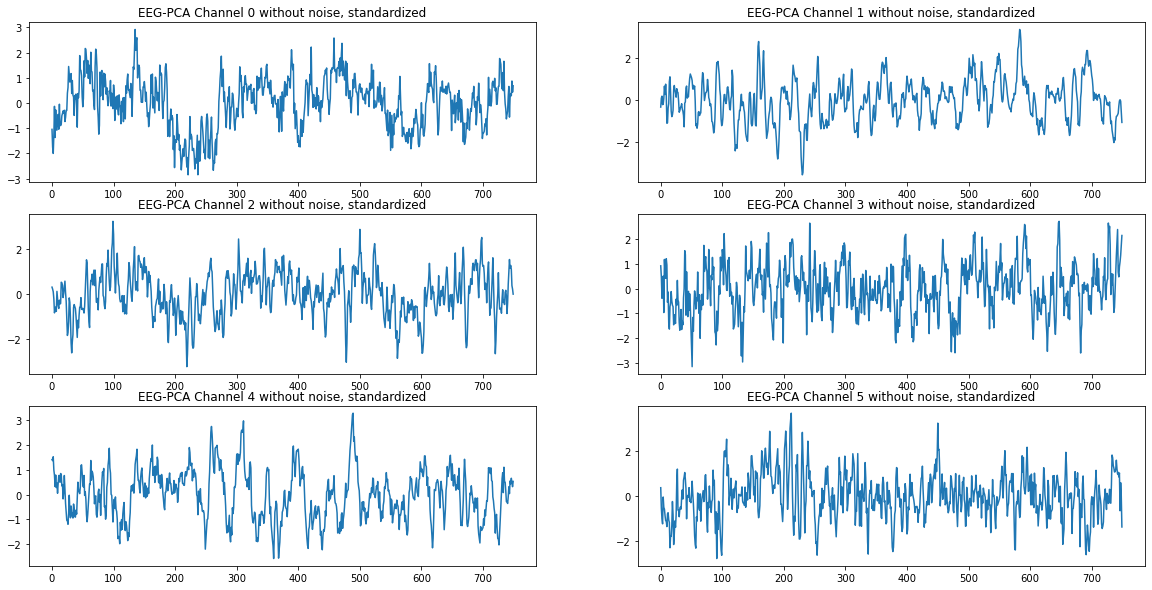

In [119]:
#normalizing each channel of a single run

fig, axs = plt.subplots(3,2,figsize=(20,10))

count = 0

eeg_ix = 10

for i in range(n_comp):
    y = X_train_valid_transformed[eeg_ix,i,:]
    mean = np.mean(y)
    std = np.std(y)
    z = (y-mean)/std
    
    axs[int(i/2),count].plot(z)
    axs[int(i/2),count].set_title('EEG-PCA Channel {} without noise, standardized'.format(i))
    
    count += 1
    if (count>1):
        count=0
    #print(np.mean(X_train_valid[eeg_ix,i,:]))
    #print(np.std(X_train_valid[eeg_ix,i,:]))

In [109]:
def ksquare(x):
    return tf.pow(x, 2)

def klog(x):
    return tf.math.log(x)

In [127]:
#n_comp = 22

# Input layer is used to instantiate a tensor
# Dimensions are (E,T) -> (22, 1000)
input_ = layers.Input(shape=(n_comp, 1000))

# Reshape layer reshapes input into given shape
# output shape is (batch_size,) + target_shape
r1 = layers.Reshape(target_shape=(n_comp, 1000, 1))(input_)

# Temporal convolution layer
# kernel_size is (H,W)
# for channels_last input is a 4D-tensor with dims batch_size + (rows, cols, )
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu')(r1)

# Permute layer
p1 = layers.Permute(dims=(2,1,3))(c1)

# Reshape layer
r2 = layers.Reshape((976, 22*40))(p1)
#r2 = layers.Reshape((726, n_comp*40))(p1)

#Dropout
#dr1 = layers.Dropout(0.8)(r2)

# FC layer
d1 = layers.Dense(40, activation='elu', kernel_regularizer='l2')(r2)
#d1 = layers.Dense(40, activation='elu')(dr1)

#Dropout
dr1 = layers.Dropout(0.25)(d1)


# Activation layer using ksquare
#sq1 = layers.Activation(ksquare)(d1)
sq1 = layers.Activation(ksquare)(dr1)

# Mean pooling layer
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)

# Log activation layer
log1 = layers.Activation(klog)(ap1)

# Flatten layer
f1 = layers.Flatten()(log1)

# Output layer
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2')(f1)

In [122]:
n_comp = 22

# Input layer is used to instantiate a tensor
# Dimensions are (E,T) -> (22, 1000)
input_ = layers.Input(shape=(n_comp, 750))

# Reshape layer reshapes input into given shape
# output shape is (batch_size,) + target_shape
r1 = layers.Reshape(target_shape=(n_comp, 750, 1))(input_)

# Temporal convolution layer
# kernel_size is (H,W)
# for channels_last input is a 4D-tensor with dims batch_size + (rows, cols, )
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu')(r1)

# Permute layer
p1 = layers.Permute(dims=(2,1,3))(c1)

# Reshape layer
#r2 = layers.Reshape((976, 22*40))(p1)
r2 = layers.Reshape((726, n_comp*40))(p1)

#Dropout
#dr1 = layers.Dropout(0.8)(r2)

# FC layer
d1 = layers.Dense(40, activation='elu', kernel_regularizer='l2')(r2)
#d1 = layers.Dense(40, activation='elu')(dr1)

#Dropout
dr1 = layers.Dropout(0.25)(d1)


# Activation layer using ksquare
#sq1 = layers.Activation(ksquare)(d1)
sq1 = layers.Activation(ksquare)(dr1)

# Mean pooling layer
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)

# Log activation layer
log1 = layers.Activation(klog)(ap1)

# Flatten layer
f1 = layers.Flatten()(log1)

# Output layer
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2')(f1)

In [128]:
model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet')
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "shallow_convnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_53 (Reshape)         (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_26 (Permute)         (None, 976, 22, 40)       0         
_________________________________________________________________
reshape_54 (Reshape)         (None, 976, 880)          0         
_________________________________________________________________
dense_48 (Dense)             (None, 976, 40)           35240     
_________________________________________________________________
dropout_26 (Dropout)         (None, 976, 40)       

In [129]:
batch_size = 32

loss_hist = model.fit(X_train_valid, y_train_valid_1h, batch_size=batch_size,
                      validation_split=0.2, epochs=50,
                      verbose=True)

hist = loss_hist.history

plt.subplot(1,2,1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

Epoch 1/50
53/53 [==============================] - 13s 241ms/step - loss: 2.4207 - acc: 0.3121 - val_loss: 2.1739 - val_acc: 0.3191
Epoch 2/50
53/53 [==============================] - 15s 289ms/step - loss: 1.9785 - acc: 0.4415 - val_loss: 2.0265 - val_acc: 0.3735
Epoch 3/50
53/53 [==============================] - 16s 306ms/step - loss: 1.7497 - acc: 0.5307 - val_loss: 1.8979 - val_acc: 0.4043
Epoch 4/50
53/53 [==============================] - 16s 301ms/step - loss: 1.5558 - acc: 0.6028 - val_loss: 1.7641 - val_acc: 0.4586
Epoch 5/50
53/53 [==============================] - 16s 299ms/step - loss: 1.3686 - acc: 0.6696 - val_loss: 1.6137 - val_acc: 0.5485
Epoch 6/50
53/53 [==============================] - 19s 361ms/step - loss: 1.2594 - acc: 0.6980 - val_loss: 1.5373 - val_acc: 0.5508
Epoch 7/50
53/53 [==============================] - 17s 312ms/step - loss: 1.1118 - acc: 0.7500 - val_loss: 1.5864 - val_acc: 0.5059
Epoch 8/50
53/53 [==============================] - 16s 301ms/step - 

KeyboardInterrupt: 

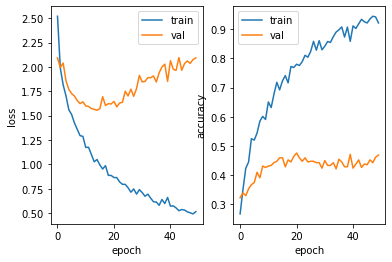

In [106]:
hist = loss_hist.history

plt.subplot(1,2,1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [ ]:
#try to do a split in time to get every other sample, so instead of 236x22x1000 we have 472x22x500 or even every 4 samples
ixs_even = np.arange(0, s2_X_train_val.shape[0] + 1, 2)
ixs_odd = np.arange(1, s2_X_train_val.shape[0] + 1, 2)